# Portfolio risk analysis under extreme market conditions
- *by Chee-Foong*
- *Apr 2020*

This analysis explores risk measures like VaR and CVar under different returns distribution regime especially during extreme market conditions like the Covid-19 pandemic crisis.

## Importing libraries and functions
- yfinance==0.1.54
- scikit-image==0.15.0
- scikit-learn==0.21.3
- scipy==1.4.1
- seaborn==0.9.0
- pandas==0.25.3
- pyportfolioopt==0.5.4
- matplotlib==3.1.3
- numpy==1.17.2
- pyfolio==0.9.2


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge import *
from risk import *

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
sns.set()

# Import the plotting library
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plt.style.use('ggplot')

## Extracting Data from Yahoo
Select list of interested yahoo tickers and the date range

In [3]:
tickers = ['AGG','GOVT','SPY']
start_date = '2012-01-01'
end_date = '2020-12-31'

Extracting data from yahoo

In [4]:
import yfinance as yf

tickerlist = {}
for ticker in tickers:
    tickerlist[ticker] = yf.Ticker(ticker).info['shortName']
    
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  3 of 3 completed


Select Adj Close prices for this analysis

In [5]:
prices = data['Adj Close'][tickers].dropna()

## Quick Analytics
### Annualised Returns and Volatilities of Assets

In [6]:
ef_analytics = ef(prices)
returns = ef_analytics.returns
cum_returns = ef_analytics.cum_returns

Analytics **before** 2020 Covid-19 crisis

In [7]:
prettyAnalytics(returns[:'2019'], tickerlist)

,Annualised Return (%),Annualised Volatility (%),Sharpe Ratio
index,,,
SPDR S&P 500,13.7753,12.8633,1.0709
iShares Core U.S. Aggregate Bon,2.82454,3.08647,0.915136
iShares U.S. Treasury Bond ETF,1.99716,3.55711,0.561456


Analytics **after** 2020 Covid-19 crisis

In [8]:
prettyAnalytics(returns[:'2020'], tickerlist)

,Annualised Return (%),Annualised Volatility (%),Sharpe Ratio
index,,,
iShares Core U.S. Aggregate Bon,3.11167,4.11655,0.755892
iShares U.S. Treasury Bond ETF,2.99484,3.98506,0.751516
SPDR S&P 500,10.5789,15.9351,0.663876


Noticed the sharpe ratio of equities has dropped and is performing worse that fixed income instruments.  Sharpe ratio for Treasury Bonds increased.

### Cumulative Returns of Assets

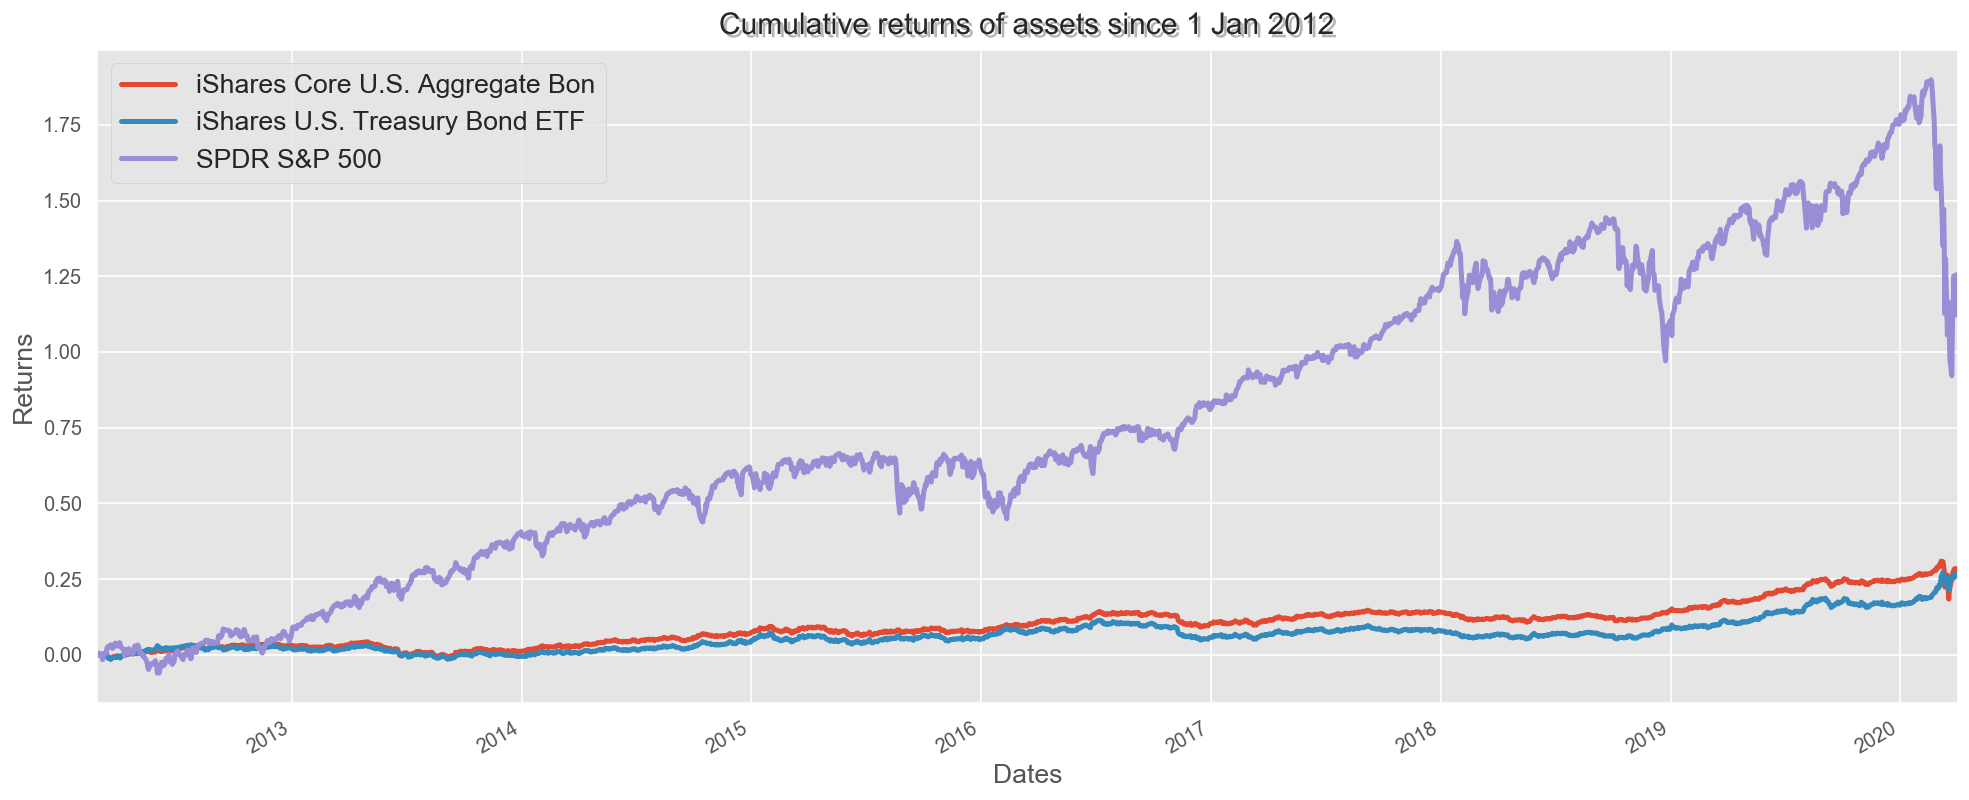

In [9]:
dt = datetime.strptime(start_date, "%Y-%m-%d").date().strftime("%-d %b %Y")
plotTimeSeries(cum_returns, 'Cumulative returns of assets since {}'.format(dt), 'Dates', 'Returns', tickerlist)

### Correlation of Assets

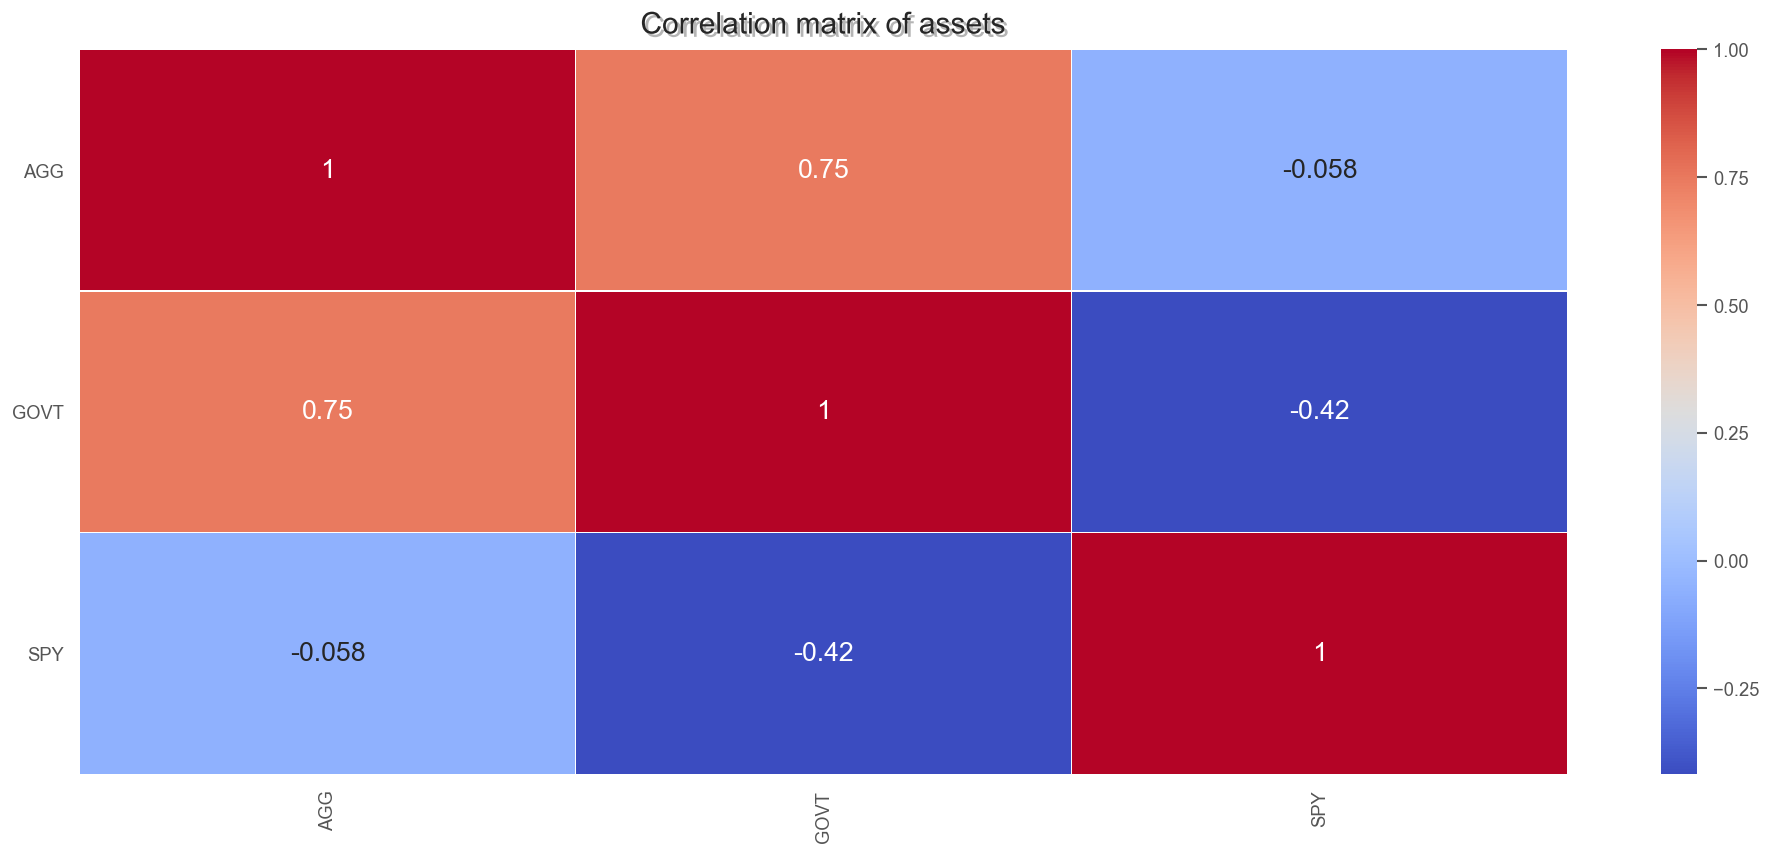

In [10]:
correlation_matrix = ef_analytics.correlation
plotCorrelationMatrix(correlation_matrix, 3, 'Correlation matrix of assets')

Higher correlation of US Aggregate Bonds and US Treasury Bonds is expected.

### Return Distribution of Assets

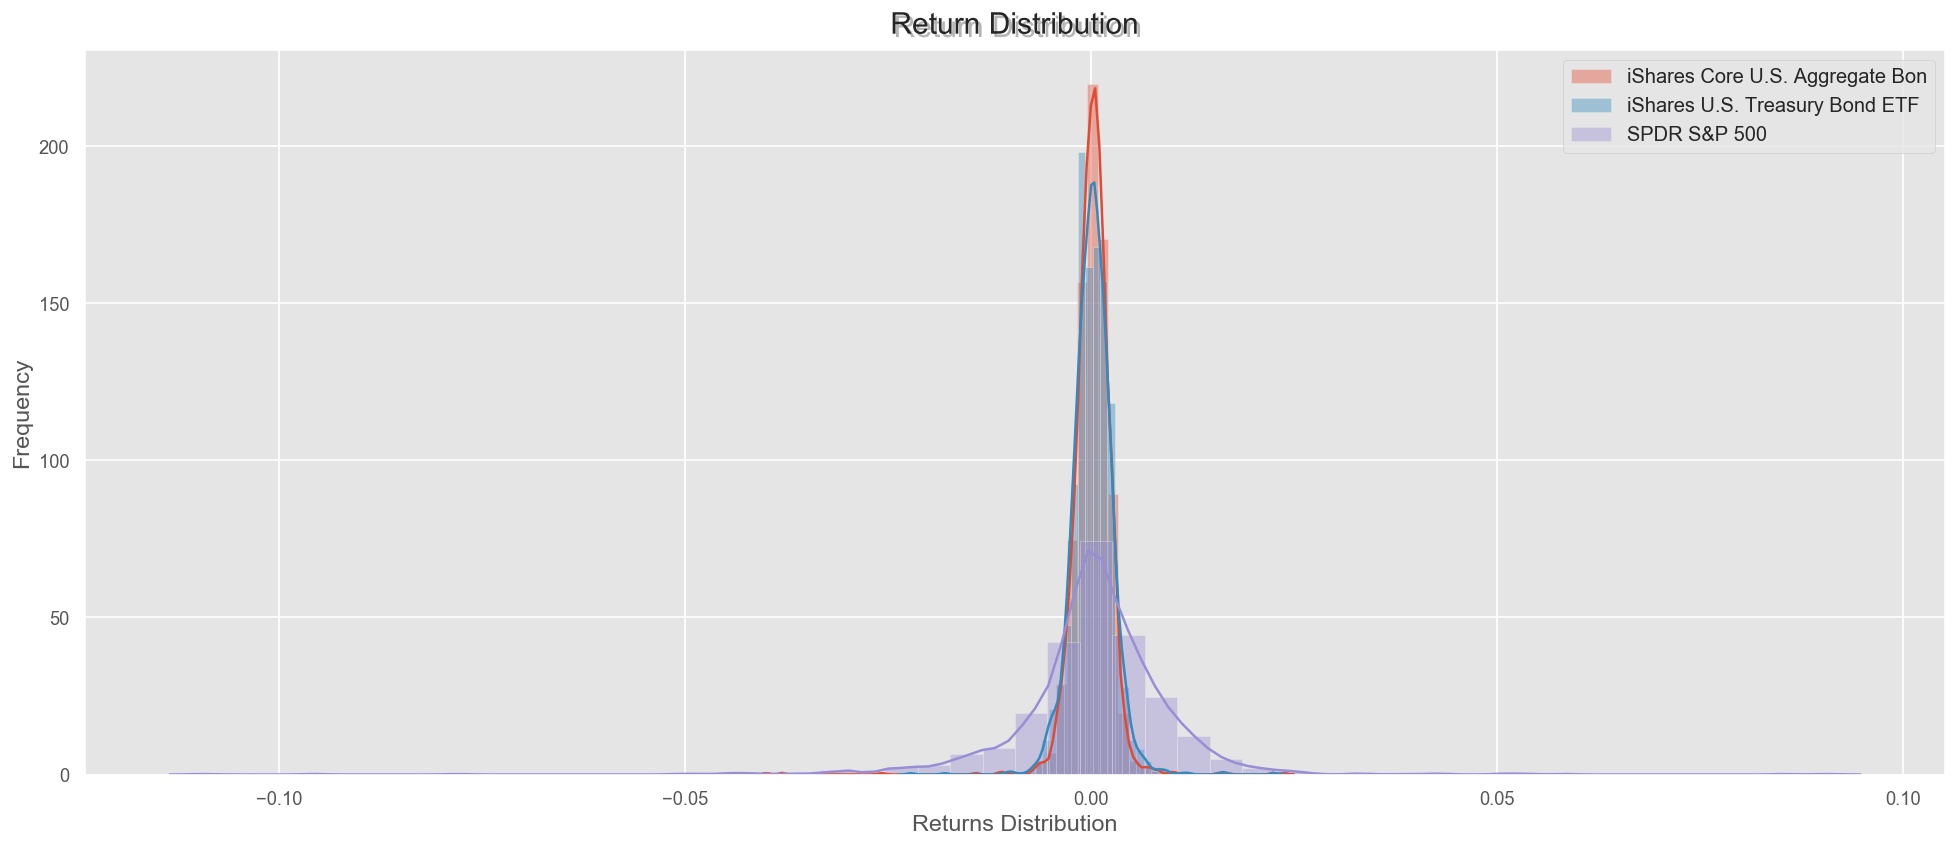

In [11]:
compareDistribution(returns, tickers, title='Return Distribution', tickermap = tickerlist)

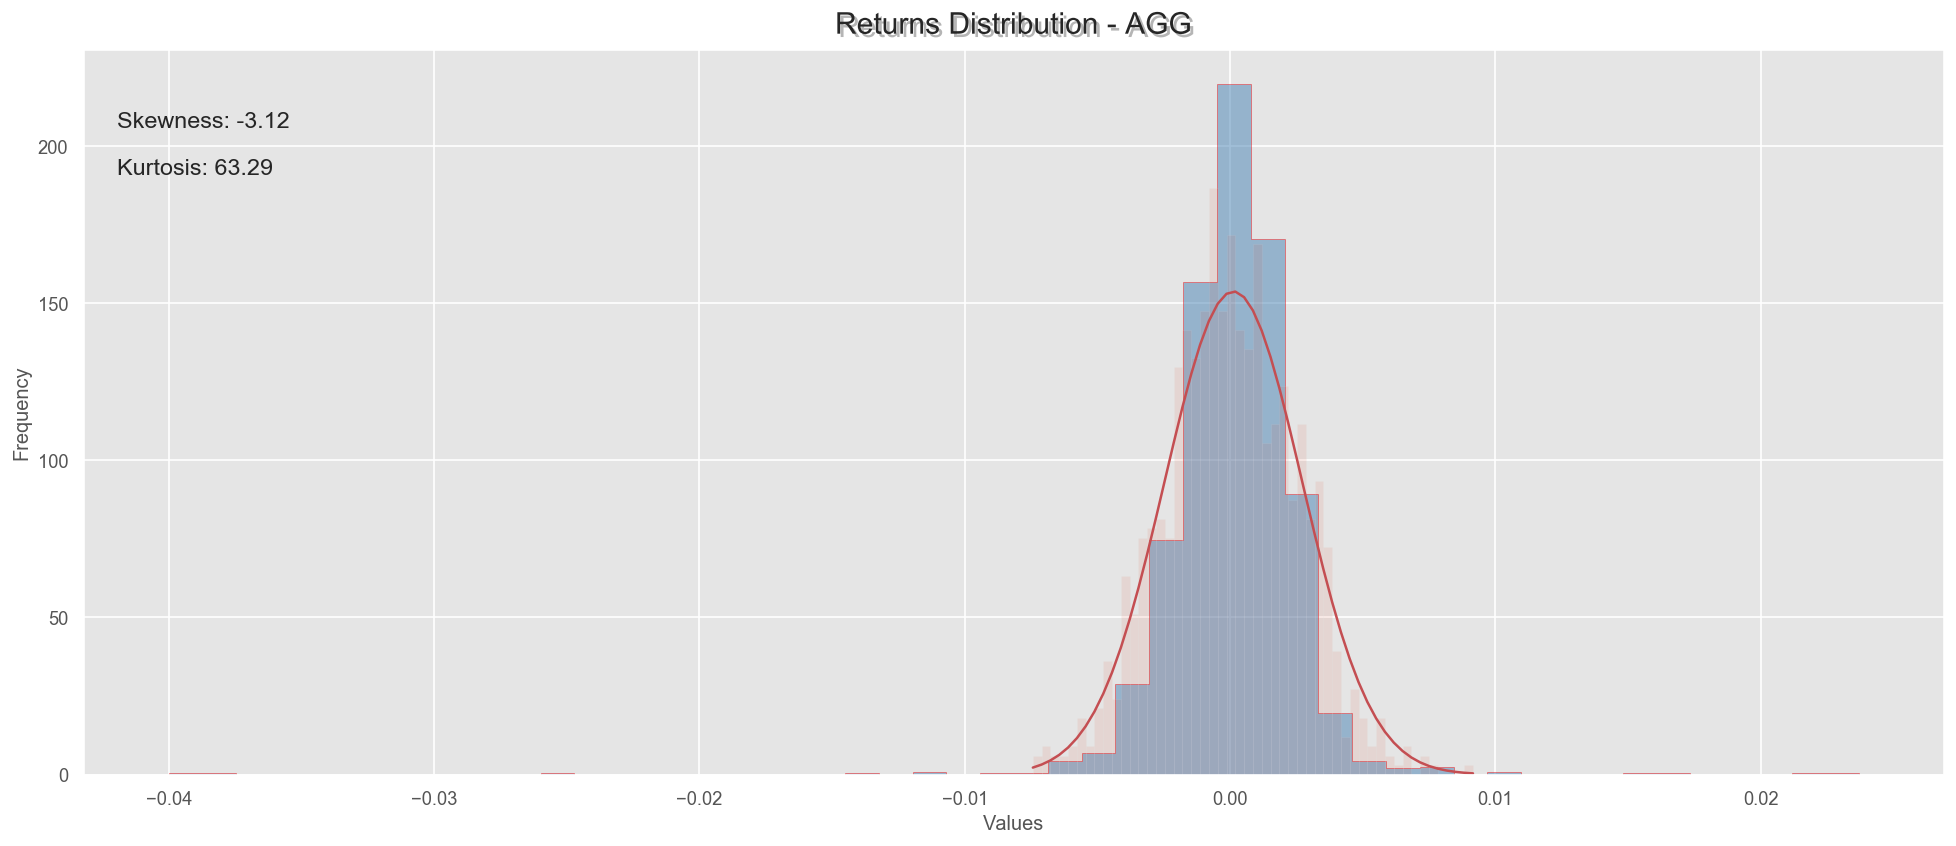

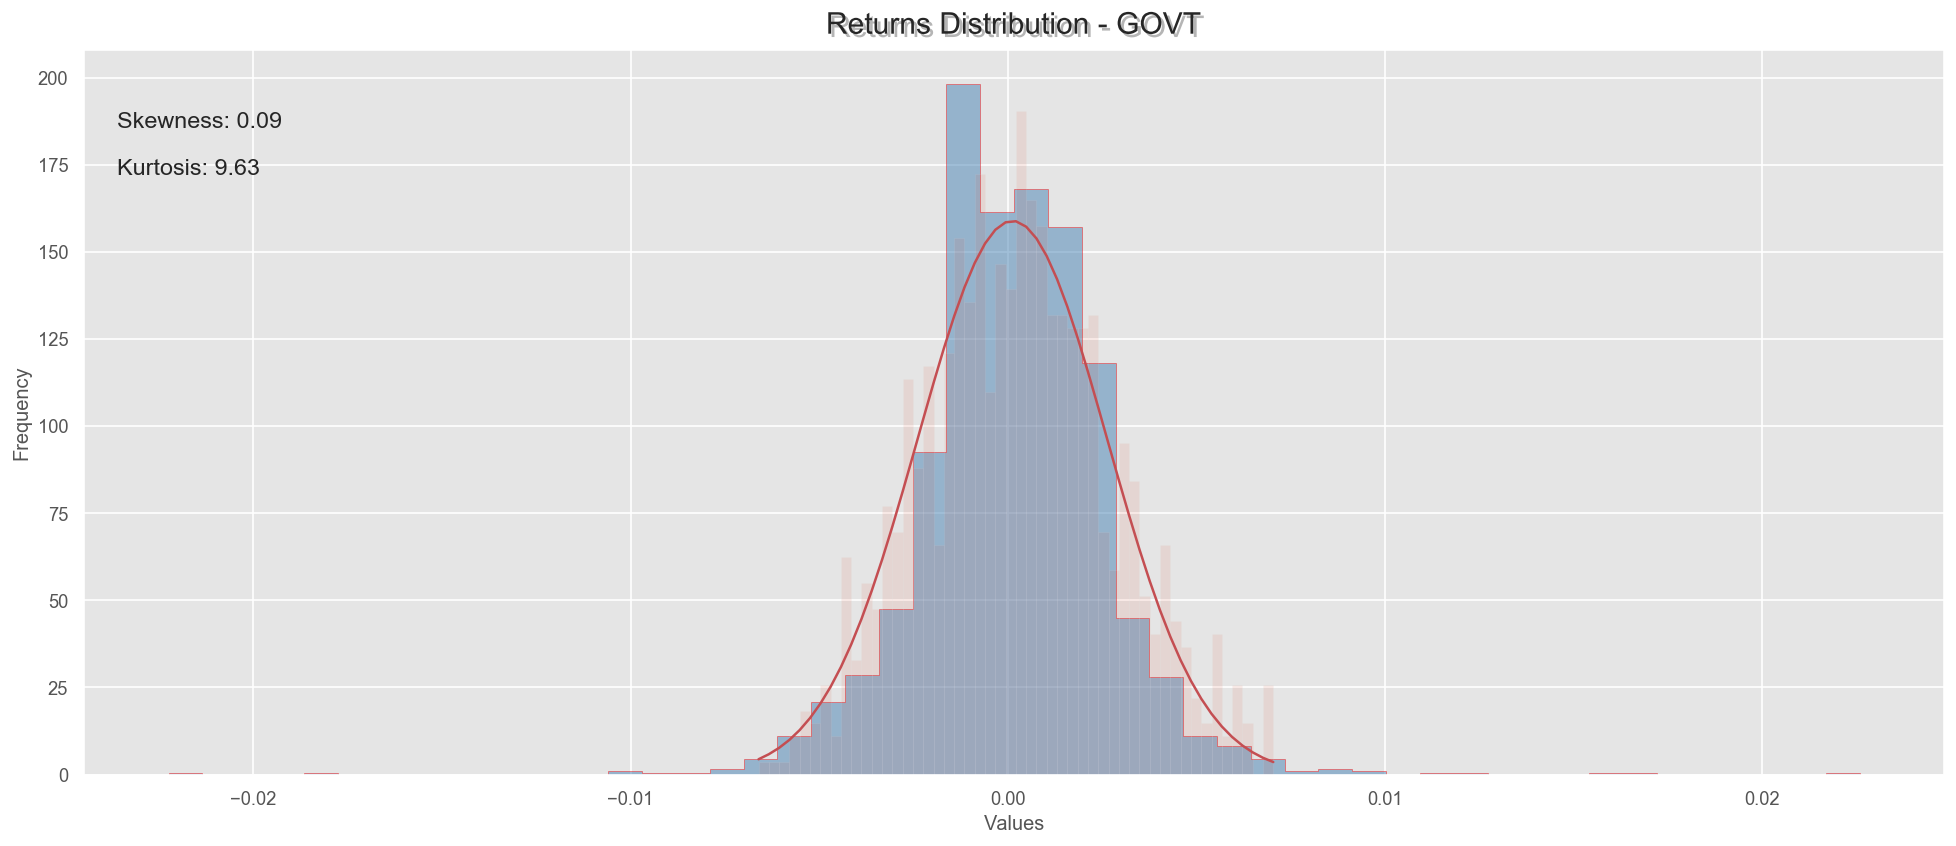

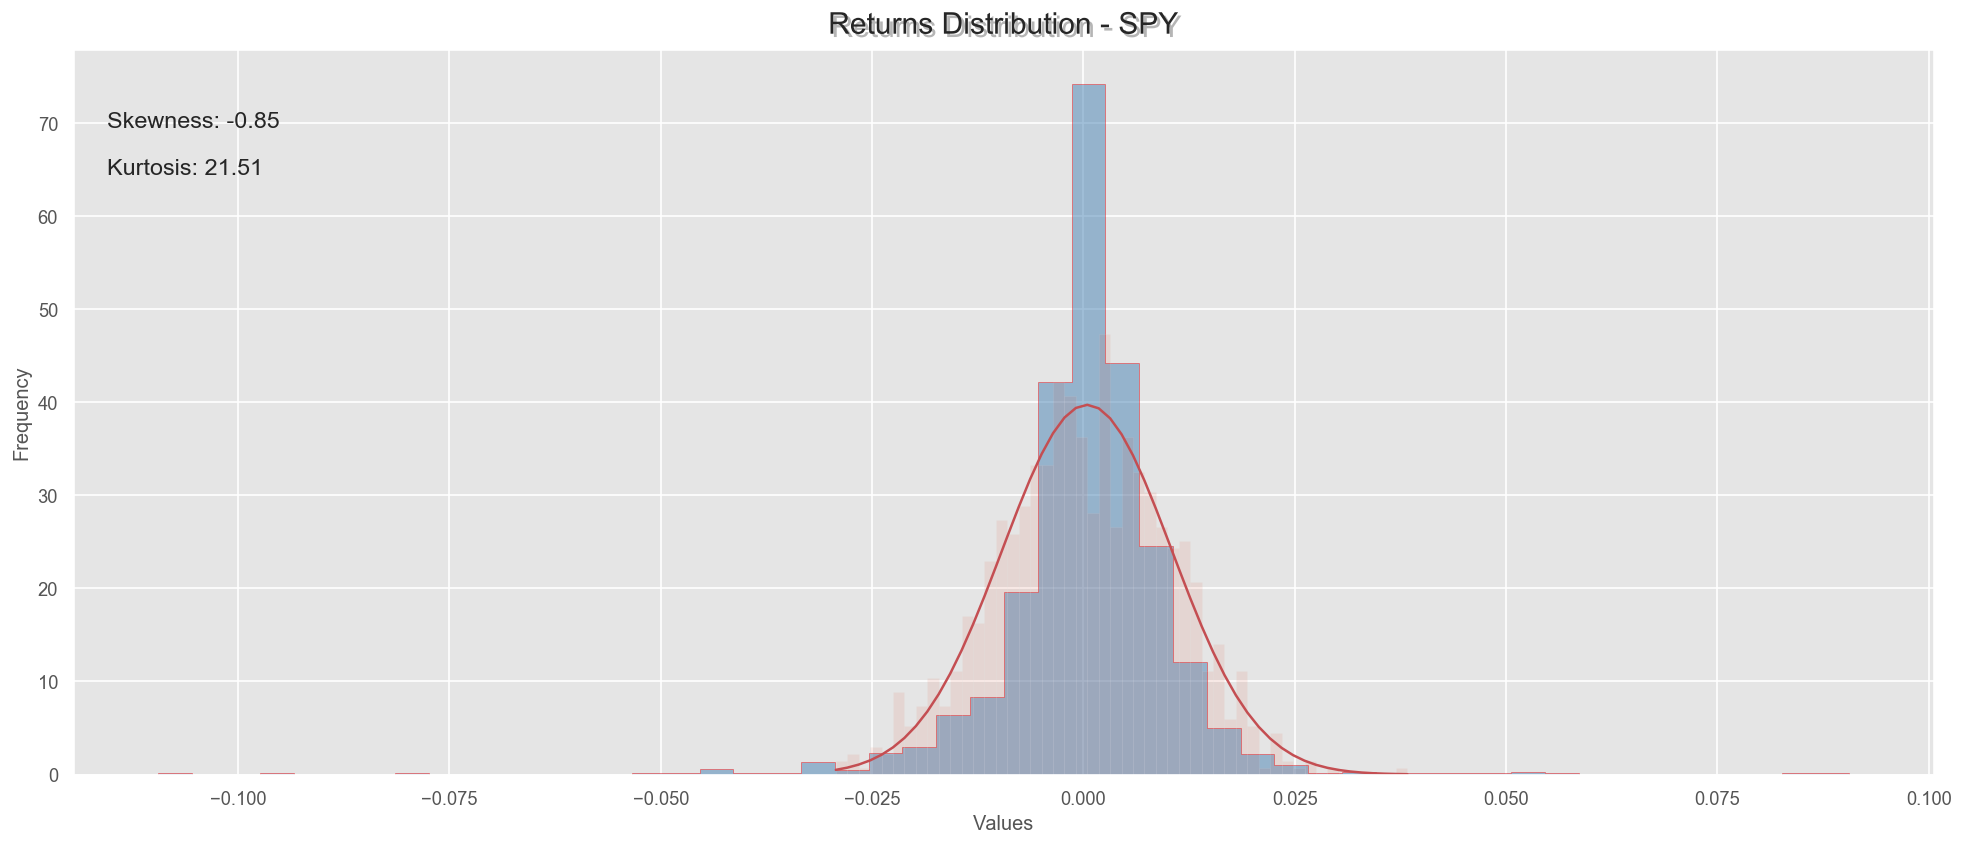

In [12]:
for ticker in tickers:
    plotReturnDistribution(returns, ticker, 50, 'Returns Distribution - {}'.format(ticker))

Noticed the high kurtosis in the assets which indicates the asset returns has heavy tails or outliers.  This translates to higher volatiity risk measures.

## Portfolio Risk Analysis

### Portfolio Composition of Interest
1. Balanced Portfolio - Equally weighted assets
2. Minimum Volatility - Efficient portfolio weights based on minimum portfolio volatility on the efficient frontier
3. Maximum Sharpe Ratio - Efficient portfolio weights based on maximum sharpe ratio on the efficient frontier

In [13]:
bal_wgts = {}
for ticker in tickers:
    bal_wgts[ticker] = 1/len(tickers)
min_vol_wgts = ef_analytics.min_volatility()
max_sharpe_wgts = ef_analytics.max_sharpe()

Portfolio Weights

In [14]:
wgts = {}
wgts['balanced'] = bal_wgts
wgts['min_vol'] = min_vol_wgts[0]
wgts['max_sharpe'] = max_sharpe_wgts[0]
pd.DataFrame(wgts)

,balanced,min_vol,max_sharpe
AGG,0.333333,0.427752,0.026070
GOVT,0.333333,0.467700,0.771347
SPY,0.333333,0.104548,0.202583


### Portfolio Contruction

In [15]:
portfolio_list = ['Balanced', 'Minimum Volatility', 'Max Sharpe Ratio']

balanced = portfolio(wgts['balanced'], prices)
min_vol = portfolio(wgts['min_vol'], prices)
max_sharpe = portfolio(wgts['max_sharpe'], prices)

### Portfolio Analysis
#### Cumulative Returns

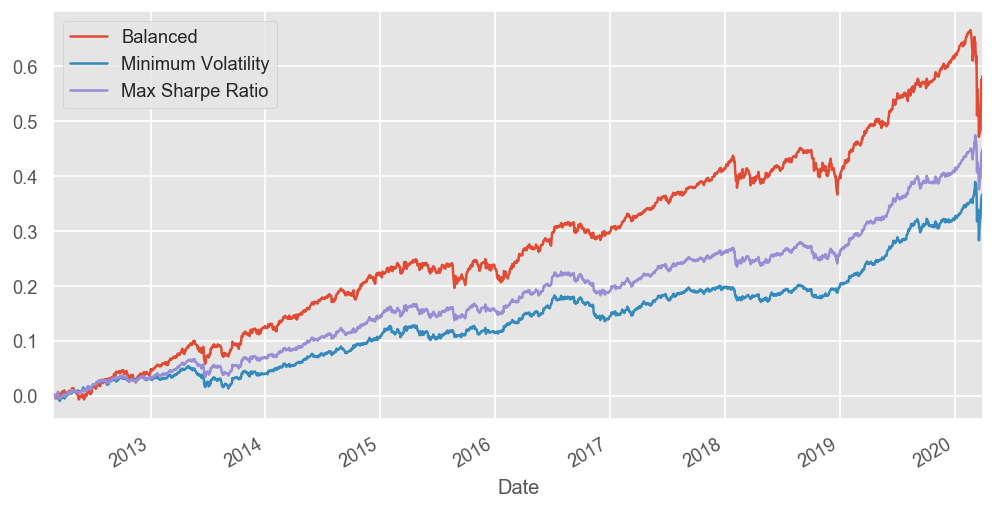

In [16]:
cum_returns = pd.concat([balanced.port_cum_returns,min_vol.port_cum_returns,max_sharpe.port_cum_returns], axis=1)
cum_returns.columns = portfolio_list
cum_returns.plot()
plt.show()

#### Portfolio Return Distribution

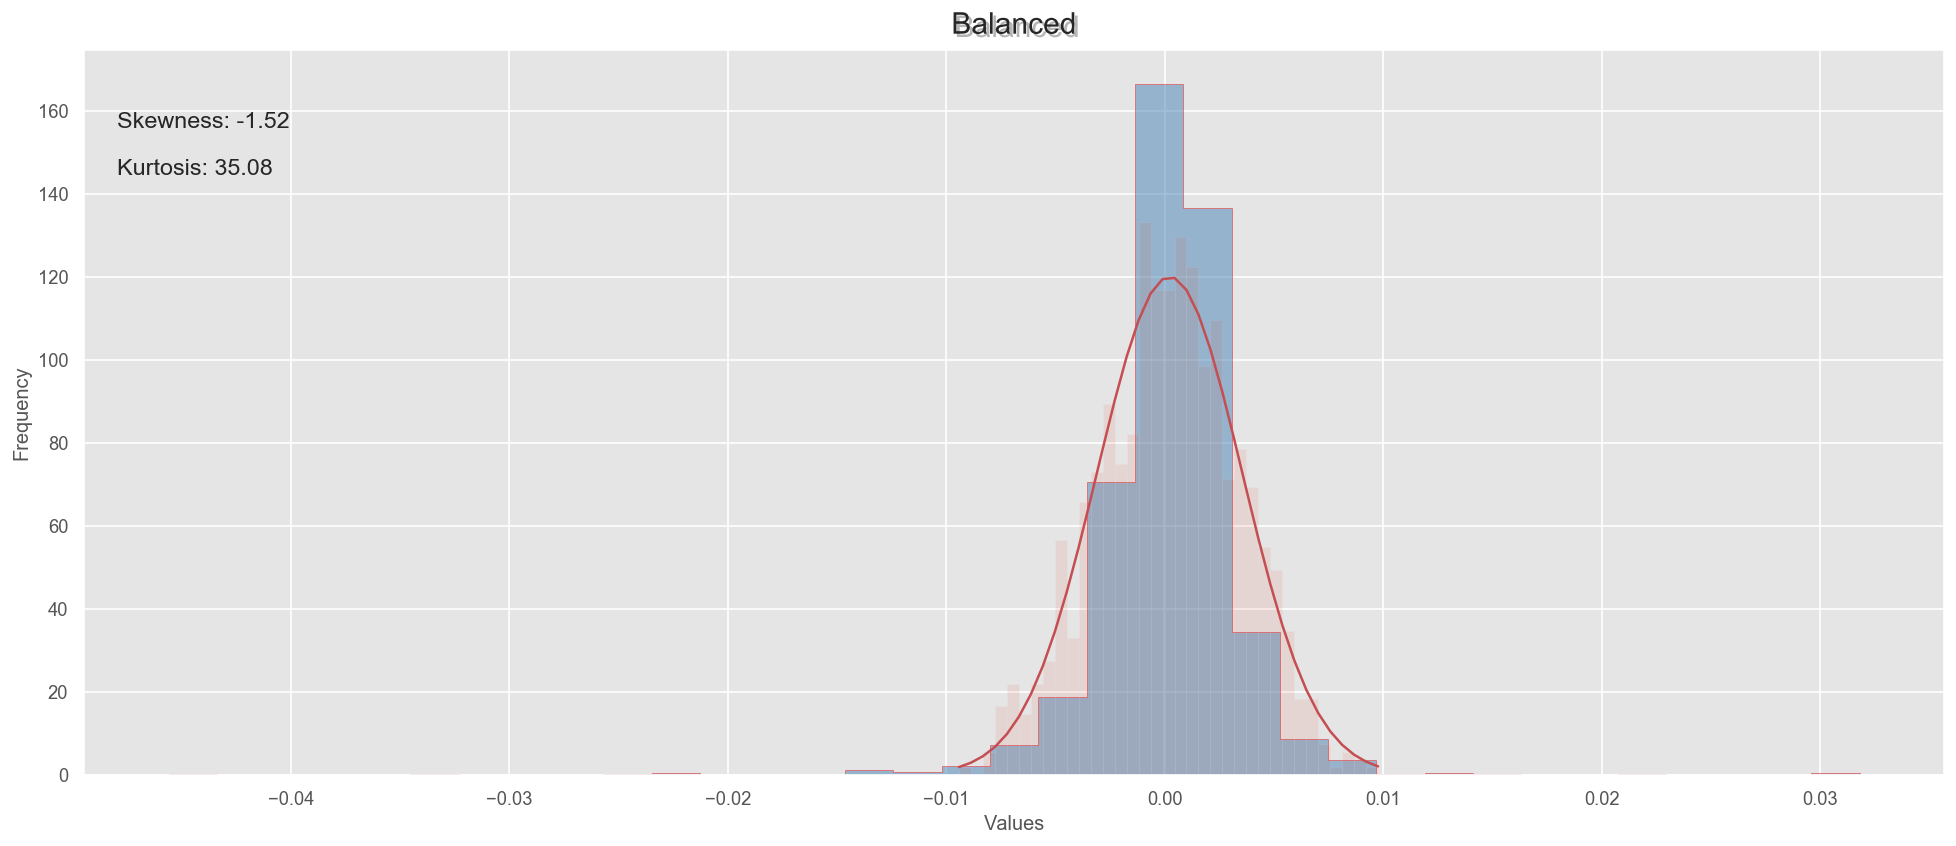

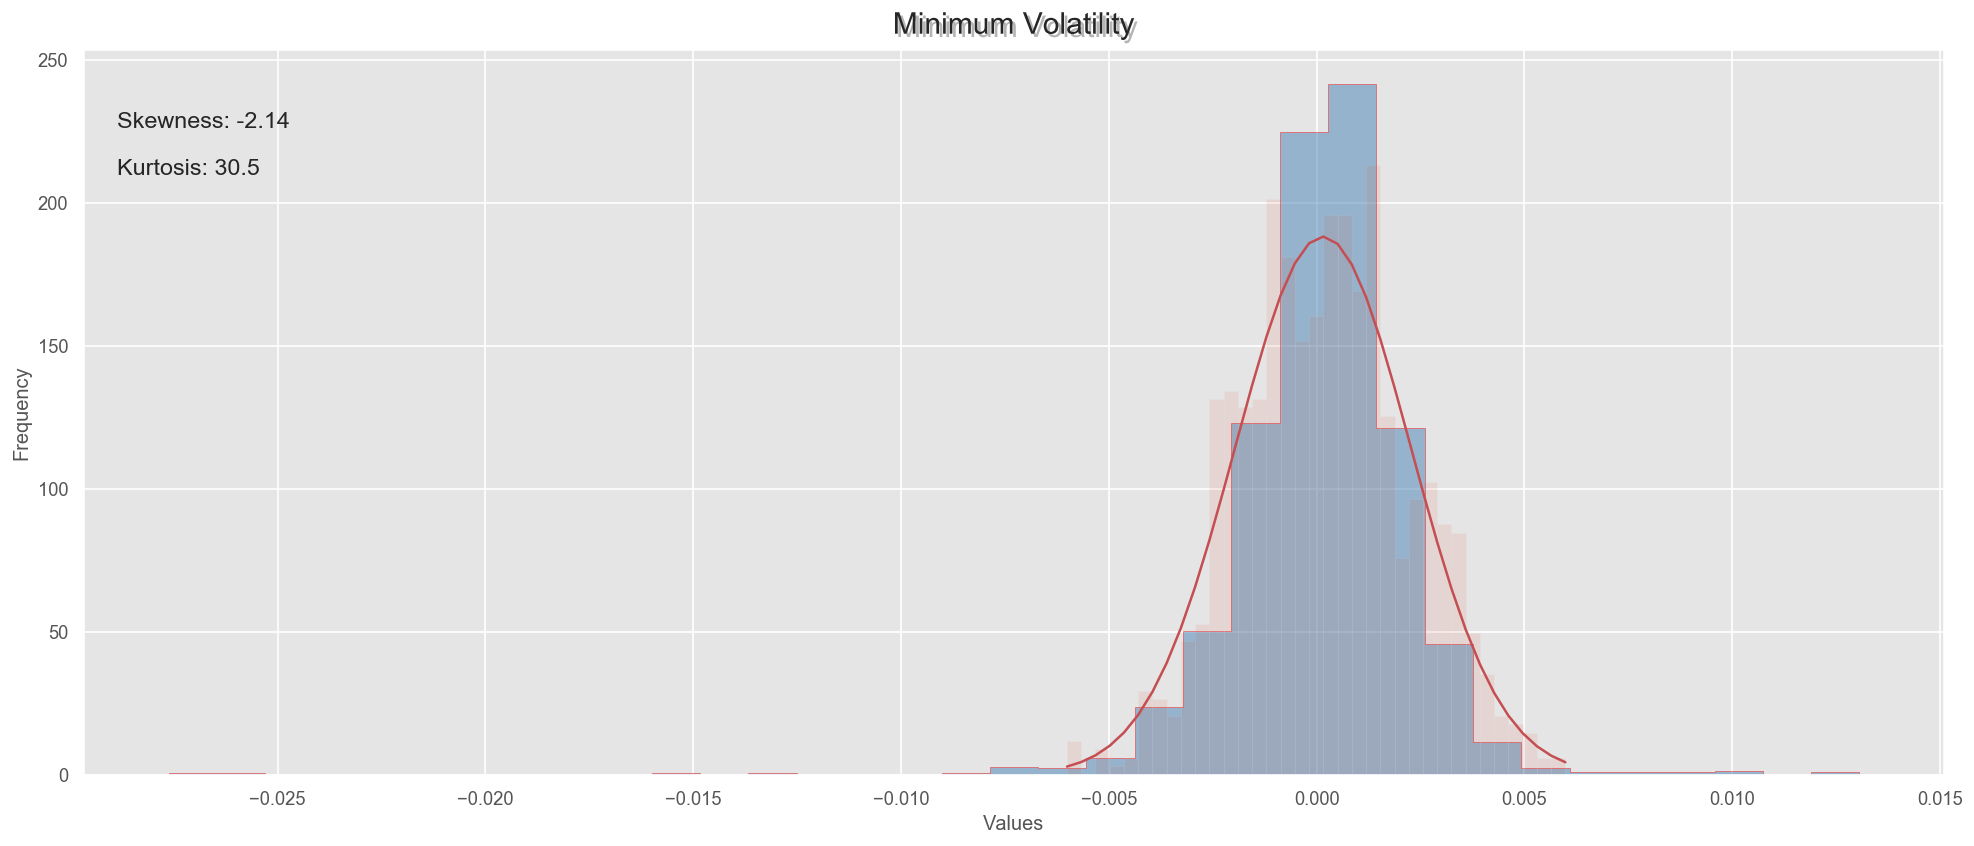

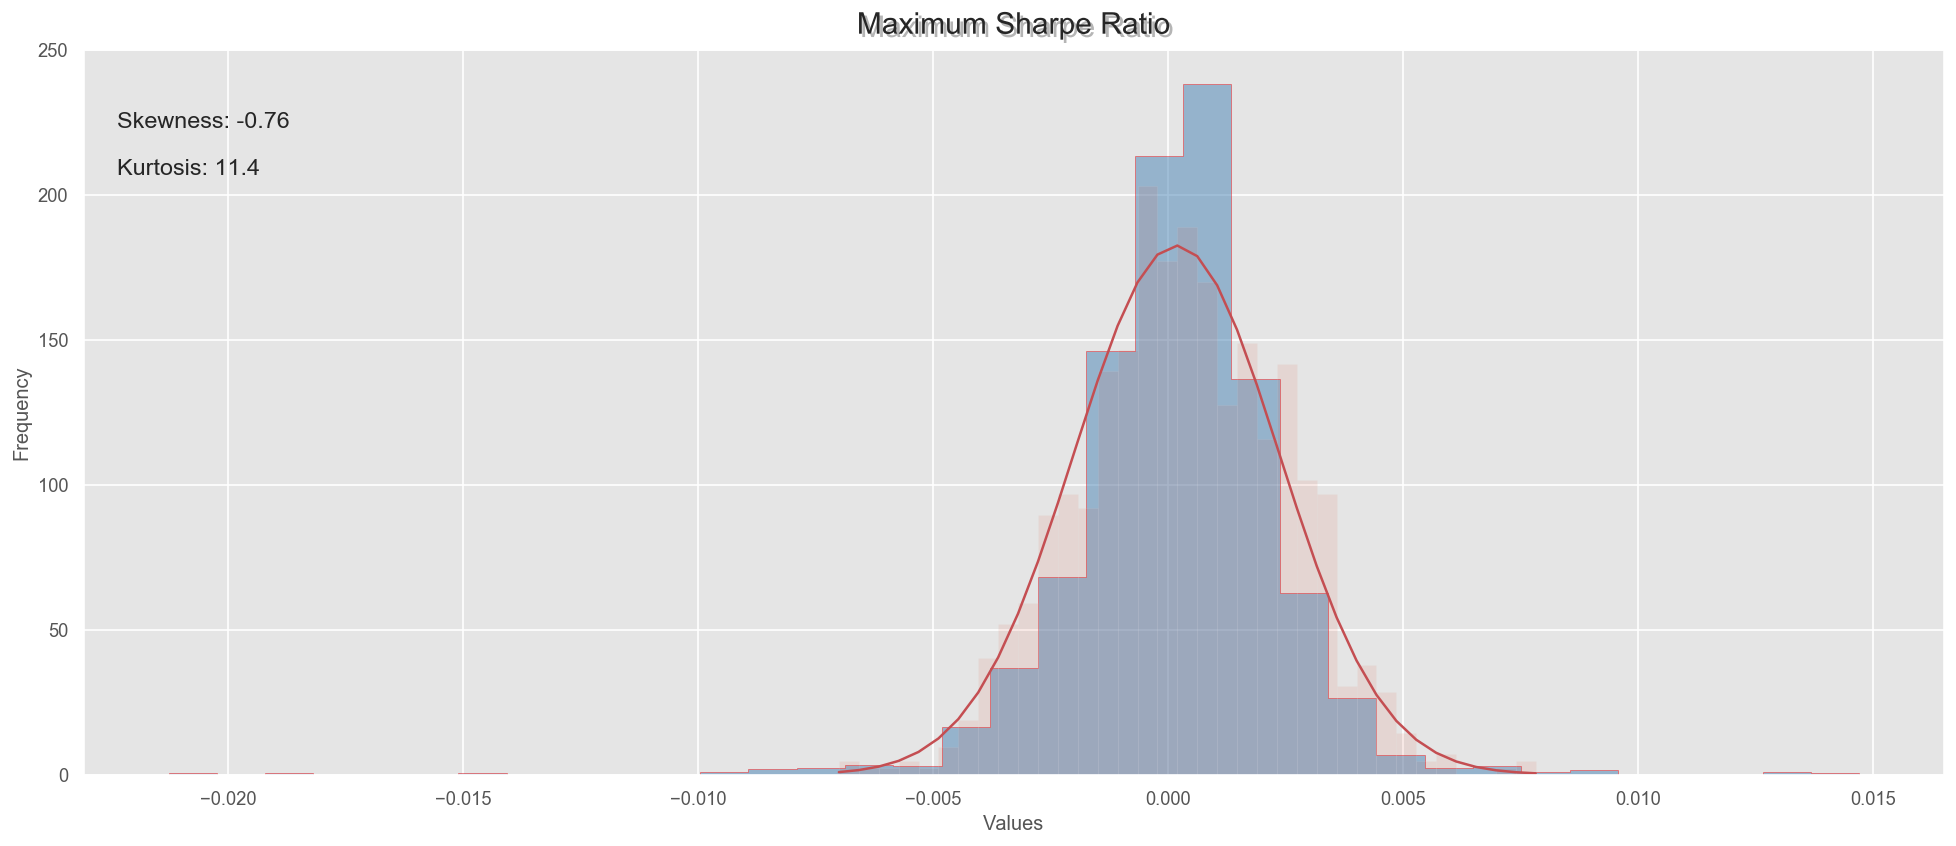

In [17]:
plotReturnDistribution(balanced.port_returns, ticker='portfolio', title='Balanced')
plotReturnDistribution(min_vol.port_returns, ticker='portfolio', title='Minimum Volatility')
plotReturnDistribution(max_sharpe.port_returns, ticker='portfolio', title='Maximum Sharpe Ratio')

### Portfolio Returns Normality Tests
#### Anderson-Darling test

Statistical test of goodness of fit
- Test null hypothesis: data are Normally distributed
- Test statistic rejects Normal distribution if larger than critical_values

In [18]:
from scipy.stats import anderson 

balanced_losses, _, _ = balanced.calc_risk()
min_vol_losses, _, _ = min_vol.calc_risk()
max_sharpe_losses, _, _ = max_sharpe.calc_risk()

Anderson-Darling test result

In [19]:
# Test the data for Normality
print("Balanced Portfolio:", anderson(balanced_losses))
print("Minimum Volatility: ", anderson(min_vol_losses))
print("Maximum Sharpe Ratio: ", anderson(max_sharpe_losses))

Balanced Portfolio: AndersonResult(statistic=49.51085600833676, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Minimum Volatility:  AndersonResult(statistic=29.365171031299724, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Maximum Sharpe Ratio:  AndersonResult(statistic=19.81238982614832, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


All Anderson-Darling test values exceeds the 99% critical value of 1.09 by a large margin, indicating that the Normal distribution may be a poor choice to represent portfolio losses.

#### Skewtest result

In [20]:
# Import the skew-normal distribution and skewness test from scipy.stats
from scipy.stats import skewnorm, skewtest, norm
# Test the data for skewness
print("Balanced Portfolio:", skewtest(balanced_losses))
print("Minimum Volatility: ", skewtest(min_vol_losses))
print("Maximum Sharpe Ratio: ", skewtest(max_sharpe_losses))

Balanced Portfolio: SkewtestResult(statistic=20.908524090890133, pvalue=4.4787383495174526e-97)
Minimum Volatility:  SkewtestResult(statistic=25.592821327287204, pvalue=1.8337763995736672e-144)
Maximum Sharpe Ratio:  SkewtestResult(statistic=12.58730747375842, pvalue=2.4798880239495585e-36)


All pvalues are very small which means the test statistics is significant and distribution is skewed.

### Portfolio VaR Calculation
Annualised VaR measure calculation on 95% confidence level.  There is a 5% probability that the portfolio will lose more than the VaR amount over a 1-year horizon period.

CVaR is the expected losses on the portfolio in the worst 95% of returns. 

#### Returns Distribution Assumption
1. Normal Distribution
2. Student-t Distribution
3. Skew-Normal Distribution
4. Gaussian Kernel Distribution


In [21]:
confidence = 0.95

portfolios = [balanced, min_vol, max_sharpe]
results = []

for pf in portfolios:
    _, Norm_VaR, Norm_CVaR = pf.calc_risk(confidence=confidence)
    _, StudT_VaR, StudT_CVaR = pf.calc_risk_t(confidence=confidence)
    _, SkewNorm_VaR, SkewNorm_CVaR = pf.calc_risk_skewnorm(confidence=confidence)
    _, GaussianK_VaR, GaussianK_CVaR = pf.calc_risk_gaussiankernel(confidence=confidence)

    VaR_List = ['Normal','Student_T','Skew_Normal','Gaussian_Kernel']
    VaR_Value = [Norm_VaR, StudT_VaR, SkewNorm_VaR, GaussianK_VaR]
    CVaR_Value = [Norm_CVaR, StudT_CVaR, SkewNorm_CVaR, GaussianK_CVaR]

    Risk_Measures = pd.DataFrame(list(zip(VaR_Value, CVaR_Value)), index=VaR_List, columns=['VaR','CVaR'])
    results.append(Risk_Measures)

95% annualised portfolio VaR and CVaR

In [22]:
for i, v in enumerate(results):
    print(portfolio_list[i])
    print(v*np.sqrt(252)*100)
    print('\n')

Balanced
                      VaR       CVaR
Normal           8.327432  10.531942
Student_T        7.044920  14.711949
Skew_Normal      8.581393  11.051750
Gaussian_Kernel  7.020187  12.286144


Minimum Volatility
                      VaR       CVaR
Normal           5.292963   6.699005
Student_T        4.986102  10.582472
Skew_Normal      5.515065   7.150310
Gaussian_Kernel  4.817928   7.691220


Max Sharpe Ratio
                      VaR       CVaR
Normal           5.418950   6.868144
Student_T        5.430406  11.484079
Skew_Normal      5.591836   7.225135
Gaussian_Kernel  5.163711   8.030259




Balanced portfolio has the highest VaR measures although it has the most impressive cumulative returns.

#### 30-Day Rolling 95% VaR

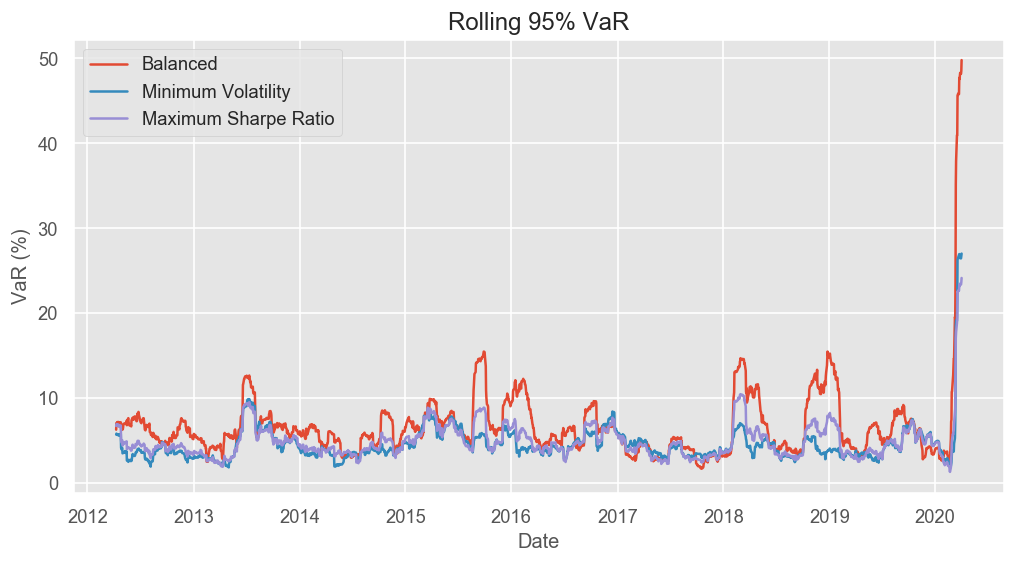

In [23]:
x_b, y_b = balanced.calc_rolling_VaR(confidence=confidence)
x_mv, y_mv = min_vol.calc_rolling_VaR(confidence=confidence)
x_ms, y_ms = max_sharpe.calc_rolling_VaR(confidence=confidence)

# Plot the minimum risk exposure over the time period
plt.plot(x_b.index, y_b*np.sqrt(252)*100, label='Balanced')
plt.plot(x_mv.index, y_mv*np.sqrt(252)*100, label='Minimum Volatility')
plt.plot(x_ms.index, y_ms*np.sqrt(252)*100, label='Maximum Sharpe Ratio')
plt.title('Rolling 95% VaR')
plt.xlabel('Date')
plt.ylabel('VaR (%)')
plt.legend()
plt.show()

Balanced portfolio consistently having higher VaR over the other 2 portfolio.  Also observed large changes in volatility over the years representing possible structural break point(s) which may require rebalancing of portfolio.

### Backtesting of Risk Measures

Testing how accurate is the VaR estimate against actual returns.  95% cutoff VaR and Student-t VaR are calculated based on past 60 days of returns.  Then percentage of the returns 60 days ahead that exceeded the VaR measure are calculated.  The percentage of returns exceeding VaR should be around 5%.  Anything greater means the model under estimated the VaR measure.  On the other hand, anything lower means the model over estimated the VaR measure.

We will use **minimum volatility portfolio** for our analysis here.

In [24]:
from tqdm import tqdm_notebook as tqdm

results = {}
window = 60
confidence = 0.95

for date in tqdm(prices.index[window:-window]):
    backtest_data = -min_vol.port_returns[date:][:window]

    estimate_data = -min_vol.port_returns[:date][-window:] 
    VaR_Cutoff = np.quantile(estimate_data, confidence)

    sample_port = portfolio(wgts['min_vol'], prices[:date][-window:])
    VaR_StudT = sample_port.calc_risk_t(confidence=confidence)[1]
    
    measure = {}
    
    # Use the 95% VaR to find extreme values from 2007-2008 losses
    extreme_Cutoff = backtest_data[backtest_data.portfolio > VaR_Cutoff]
    extreme_StudT = backtest_data[backtest_data.portfolio > VaR_StudT]
    measure['Pct_cutoff'] = len(extreme_Cutoff) / len(backtest_data)
    measure['Pct_student-t'] = len(extreme_StudT) / len(backtest_data)
    measure['VaR_cutoff'] = VaR_Cutoff
    measure['VaR_student-t'] = VaR_StudT
    
    results[date] = measure

    # Compare the fraction of extreme values for 2007-2008 to the Var_95 estimate
    # print("95% Daily VaR: {:.5f}".format(VaR_95))
    # print("Percentage of daily backtest returns exceeding 95% VaR: {:.2f}%".format(len(extreme_values) / len(backtest_data)*100))
    

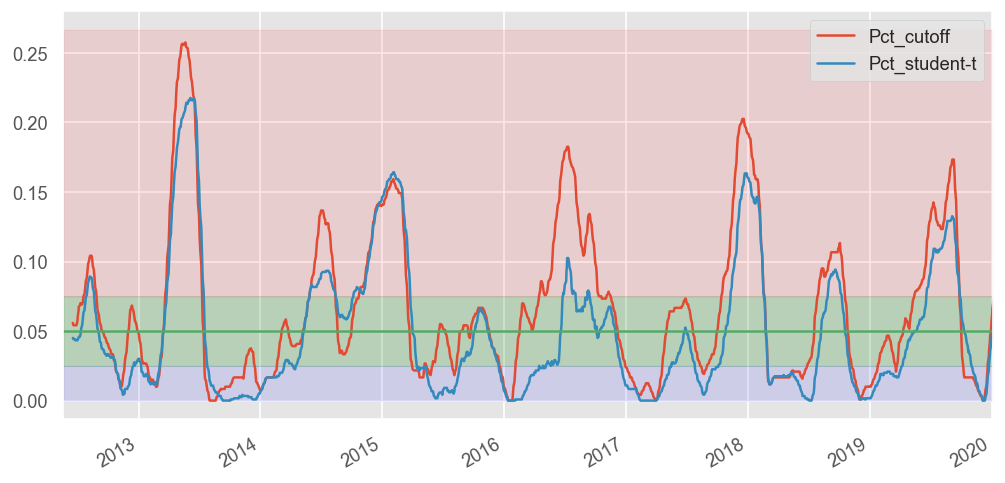

In [25]:
data = pd.DataFrame(results).T
data.iloc[:,0:2].rolling(20).mean().plot()
y_min = data.iloc[:,0:2].rolling(20).min().min().min()
y_max = data.iloc[:,0:2].rolling(20).max().max().max()

plt.axhline(y=0.05, color='g', linestyle='-')
plt.fill_between(x=data.index, y1=0.025, y2=0.075, color='green', alpha=0.2)
plt.fill_between(x=data.index, y1=0.025, y2=y_min, interpolate=True, color='blue', alpha=0.1)
plt.fill_between(x=data.index, y1=0.075, y2=y_max, interpolate=True, color='red', alpha=0.1)
plt.show()

Note the red line is consistently above the blue line.  This shows that a larger number of returns exceeded the cutoff VaR measure more than the Student-t VaR measure.  Which also means that cutoff VaR is a poorer estimator of portfolio risk.

The plot below confirms the Student-t VaR measure is consistently higher than the cutoff VaR.

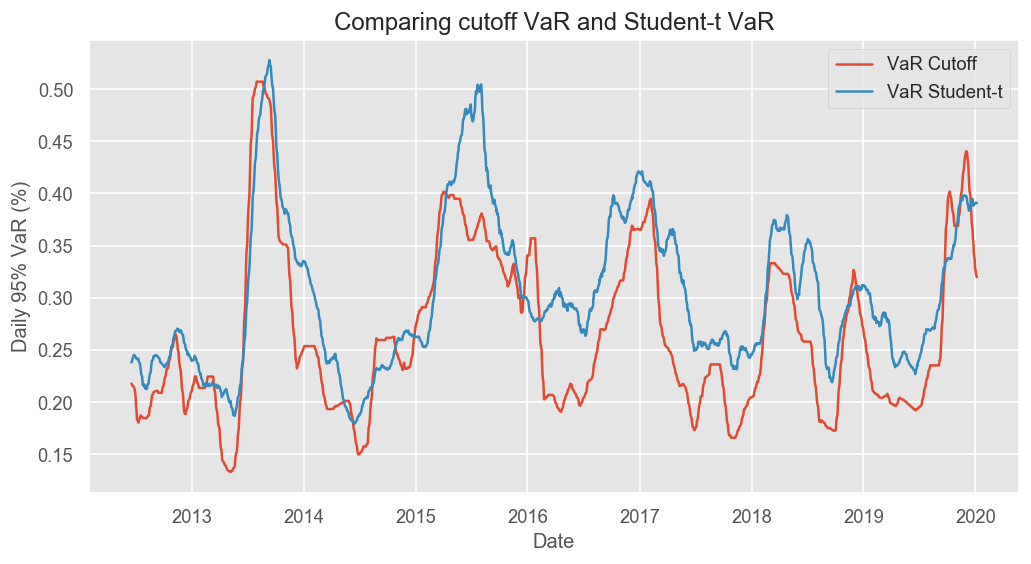

In [26]:
data2 = data.iloc[:,2:].rolling(20).mean()*100
plt.plot(data2.index, data2['VaR_cutoff'], label='VaR Cutoff')
plt.plot(data2.index, data2['VaR_student-t'], label='VaR Student-t')

plt.xlabel('Date')
plt.ylabel('Daily 95% VaR (%)')
plt.title('Comparing cutoff VaR and Student-t VaR')
plt.legend()
plt.show()

### Extreme Value Theory
#### Clustering of extreme values
Using Student-t VaR for the portfolio, plot and observe the extreme values that exceeded VaR.  Clustering of extreme values represents periods of possible structural breaks.  As expected, clustering of extreme values contributes to higher rolling VaR.

We will use **minimum volatility portfolio** for our analysis here.

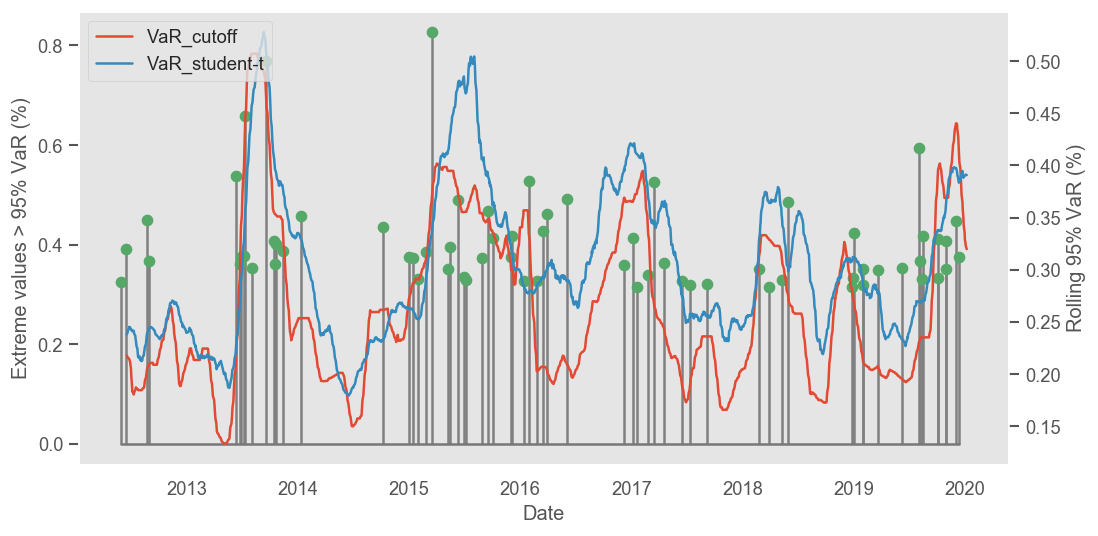

In [27]:
VaR_StudT = min_vol.calc_risk_t(confidence=confidence)[1]
extreme_values = min_vol.port_returns[min_vol.port_returns.portfolio > VaR_StudT]

fig,ax = plt.subplots()
dates = [date for date in extreme_values.index if date in data.index]
extreme_values = extreme_values.loc[dates]


ax.stem(extreme_values.index, extreme_values*100, linefmt='grey', markerfmt='go', use_line_collection=True)
ax.set_ylabel("Extreme values > 95% VaR (%)")
ax.set_xlabel("Date")
ax.grid(False)

ax2=ax.twinx()
ax2.set_ylabel("Rolling 95% VaR (%)")
ax2.plot(data.iloc[:,2:].rolling(20).mean()*100)
ax2.grid(False)
ax2.legend(data.iloc[:,2:].columns, loc='upper left')

plt.show()

Studying the weekly maxima of the portfolio losses.

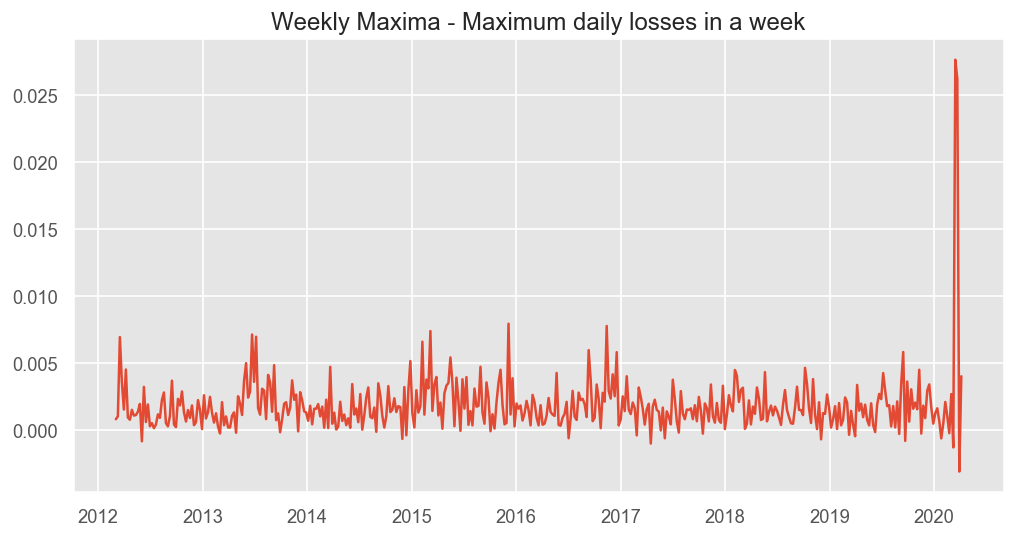

In [28]:
losses = -min_vol.port_returns

# Resample the data into weekly blocks
weekly_maxima = losses.resample("W").max()

# Plot the resulting weekly maxima
plt.title('Weekly Maxima - Maximum daily losses in a week')
plt.plot(weekly_maxima)
plt.show()

Using weekly maxima to estimate the 1 week 95% VaR based on Generalized Extreme Value Distribution (GEV)

In [29]:
from scipy.stats import genextreme

losses = -min_vol.port_returns

# Resample the data into weekly blocks
weekly_losses = losses.resample("W").max().iloc[:,0]
# weekly_max = losses.resample("W").apply(lambda x: ((x + 1).cumprod() - 1).last("D")).iloc[:,0]

VaR: 0.043492630048973274
CVaR: 0.15261569047634876


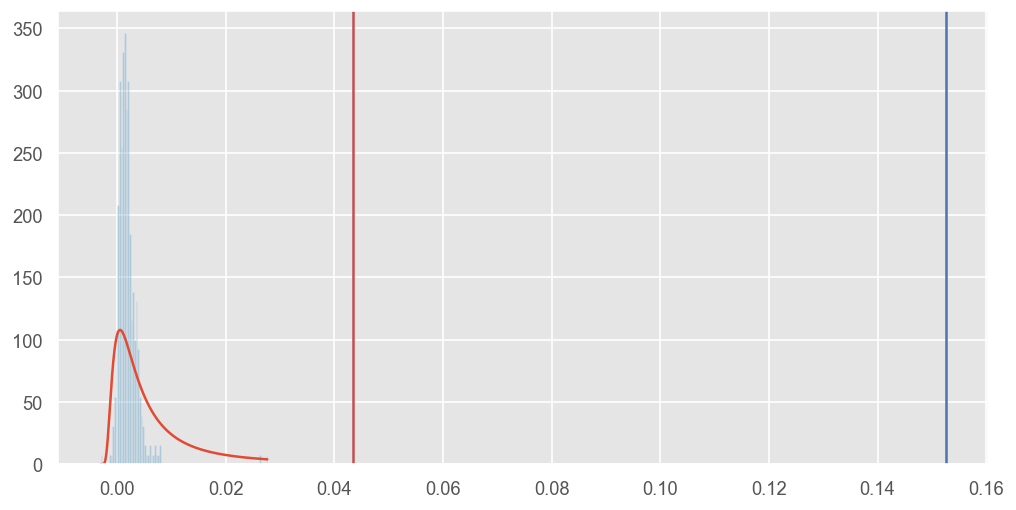

In [30]:
confidence = 0.95

# Fit extreme distribution to weekly maximum of losses
params = genextreme.fit(weekly_losses)

VaR = genextreme.ppf(confidence, *params)

# Compute the CVaR estimate
CVaR = (1 / (1 - confidence)) * genextreme.expect(lambda x: x, args=(params[0],), 
                                               loc = params[1], scale = params[2], lb = VaR)

print('VaR: {}'.format(VaR))
print('CVaR: {}'.format(CVaR))

# Plot extreme distribution with weekly max losses historgram
x = np.linspace(min(weekly_losses), max(weekly_losses), 1000)
plt.plot(x, genextreme.pdf(x, *params))
plt.hist(weekly_losses, 100, density = True, alpha = 0.3)
plt.axvline(VaR, c='r')
plt.axvline(CVaR, c='b')
plt.show()


Based on extreme value theory, the 95% weekly CVaR is 15.26%.

# END